In [50]:
import requests
from bs4 import BeautifulSoup
import re
import os
from datetime import datetime
import glob
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# URL of the webpage to scrape
url = 'https://www.nhsbsa.nhs.uk/prescription-data/dispensing-data/complete-new-medicine-service-data'

# Directory to save downloaded files
download_dir = '../data/nms_data'

# Create the directory if it does not exist
if not os.path.exists(download_dir):
    os.makedirs(download_dir)

In [8]:
# Function to convert month name and year to YYYYMM format
def convert_to_yyyymm(filename):
    # Extract the month and year from the filename
    match = re.search(r'Completed%20NMS%20data%20([A-Za-z]+)%20(\d{2,4})', filename)
    if match:
        month = match.group(1)
        year = match.group(2)
        
        # Handle two-digit years
        if len(year) == 2:
            year = '20' + year
        
        # Convert month name or abbreviation to month number
        try:
            month_number = datetime.strptime(month, '%B').month
        except ValueError:
            month_number = datetime.strptime(month, '%b').month
        
        # Format as YYYYMM
        return f'{year}{month_number:02d}.xlsx'
    return filename

# Send a GET request to the webpage
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Parse the webpage content
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Find all links that end with .xls or .xlsx
    file_links = soup.find_all('a', href=re.compile(r'(\.xls$|\.xlsx$)'))
    
    # Download each file
    for link in file_links:
        file_url = link.get('href')
        if not file_url.startswith('http'):
            file_url = 'https://www.nhsbsa.nhs.uk' + file_url
        
        # Get the original filename
        original_filename = file_url.split('/')[-1]
        
        # Convert to YYYYMM format
        new_filename = convert_to_yyyymm(original_filename)
        filename = os.path.join(download_dir, new_filename)
        
        # Download the file and save it
        file_response = requests.get(file_url)
        if file_response.status_code == 200:
            with open(filename, 'wb') as file:
                file.write(file_response.content)
            print(f"Downloaded: {filename}")
        else:
            print(f"Failed to download: {file_url}")

else:
    print(f"Failed to retrieve the webpage. Status code: {response.status_code}")

# List the downloaded files
downloaded_files = os.listdir(download_dir)
print(downloaded_files)

Downloaded: ../data/nms_data/202401.xlsx
Downloaded: ../data/nms_data/202402.xlsx
Downloaded: ../data/nms_data/202403.xlsx
Downloaded: ../data/nms_data/202301.xlsx
Downloaded: ../data/nms_data/202302.xlsx
Downloaded: ../data/nms_data/202303.xlsx
Downloaded: ../data/nms_data/202304.xlsx
Downloaded: ../data/nms_data/202305.xlsx
Downloaded: ../data/nms_data/202306.xlsx
Downloaded: ../data/nms_data/202307.xlsx
Downloaded: ../data/nms_data/202308.xlsx
Downloaded: ../data/nms_data/202309.xlsx
Downloaded: ../data/nms_data/202310.xlsx
Downloaded: ../data/nms_data/202311.xlsx
Downloaded: ../data/nms_data/202312.xlsx
Downloaded: ../data/nms_data/202201.xlsx
Downloaded: ../data/nms_data/202202.xlsx
Downloaded: ../data/nms_data/202203.xlsx
Downloaded: ../data/nms_data/202204.xlsx
Downloaded: ../data/nms_data/202205.xlsx
Downloaded: ../data/nms_data/202206.xlsx
Downloaded: ../data/nms_data/202207.xlsx
Downloaded: ../data/nms_data/202208.xlsx
Downloaded: ../data/nms_data/202209.xlsx
Downloaded: ../d

In [4]:
file_list = glob.glob(os.path.join(download_dir, '*.xlsx'))
file_list

['../data/nms_data/201601.xlsx',
 '../data/nms_data/201602.xlsx',
 '../data/nms_data/201603.xlsx',
 '../data/nms_data/201604.xlsx',
 '../data/nms_data/201605.xlsx',
 '../data/nms_data/201606.xlsx',
 '../data/nms_data/201607.xlsx',
 '../data/nms_data/201608.xlsx',
 '../data/nms_data/201609.xlsx',
 '../data/nms_data/201610.xlsx',
 '../data/nms_data/201611.xlsx',
 '../data/nms_data/201710.xlsx',
 '../data/nms_data/201711.xlsx',
 '../data/nms_data/201712.xlsx',
 '../data/nms_data/201801.xlsx',
 '../data/nms_data/201802.xlsx',
 '../data/nms_data/201803.xlsx',
 '../data/nms_data/201804.xlsx',
 '../data/nms_data/201805.xlsx',
 '../data/nms_data/201806.xlsx',
 '../data/nms_data/201807.xlsx',
 '../data/nms_data/201808.xlsx',
 '../data/nms_data/201809.xlsx',
 '../data/nms_data/201810.xlsx',
 '../data/nms_data/201811.xlsx',
 '../data/nms_data/201812.xlsx',
 '../data/nms_data/201901.xlsx',
 '../data/nms_data/201902.xlsx',
 '../data/nms_data/201903.xlsx',
 '../data/nms_data/201904.xlsx',
 '../data/

In [41]:
def extract_nms_count(file_path, debug=False):
    print (file_path)
    # Use a regular expression to find the YYYYMM pattern
    match = re.search(r'(\d{6})\.xlsx$', file_path)
    
    # Extract the matched pattern if it exists
    yyyymm = match.group(1) if match else None

    excel_data = pd.ExcelFile(file_path)
    
    # Function to load the appropriate sheet
    def load_sheet(file_path, possible_sheets, skiprows):
        excel_data = pd.ExcelFile(file_path)
        sheet_name = None
        for sheet in possible_sheets:
            if sheet in excel_data.sheet_names:
                sheet_name = sheet
                break
        if sheet_name:
            return pd.read_excel(file_path, sheet_name=sheet_name, skiprows=skiprows)
        else:
            raise ValueError(f"None of the specified sheets {possible_sheets} exist in the file.")
    
    # Possible sheet names to look for
    possible_sheets = ['NHS England Area', 'STP', 'ICB']
    
    # Load the appropriate sheet
    df_cleaned = load_sheet(file_path, possible_sheets, skiprows=2)
    
    # Rename the columns to meaningful names
    df_cleaned.columns = ['NHS England Area Code', 'NHS England Area', 'Completed NMS Claimed on FP34C', 'Payment (£)']
    
    # Drop any rows that have all NaN values
    df_cleaned.dropna(how='all', inplace=True)

    # Normalize the 'NHS England Area Code' to upper case for comparison
    df_cleaned['NHS England Area Code'] = df_cleaned['NHS England Area Code'].str.upper()

    if debug:
        print (df_cleaned)
    
    # Filter the row where 'NHS England Area Code' equals 'Total'
    total_row = df_cleaned[df_cleaned['NHS England Area Code'] == 'TOTAL']

    if debug:
        print (total_row)
    
    # Extract the value for 'Completed NMS Claimed on FP34C'
    completed_nms_claimed_total = total_row['Completed NMS Claimed on FP34C'].values[0] if not total_row.empty else None
    
    #print(f"Completed NMS Claimed on FP34C for 'Total': {completed_nms_claimed_total}")
    return {'month': yyyymm, 'count': completed_nms_claimed_total}

In [42]:
results=[]
for file_path in file_list:
    res=extract_nms_count(file_path)
    results.append(res)

../data/nms_data/201601.xlsx
../data/nms_data/201602.xlsx
../data/nms_data/201603.xlsx
../data/nms_data/201604.xlsx
../data/nms_data/201605.xlsx
../data/nms_data/201606.xlsx
../data/nms_data/201607.xlsx
../data/nms_data/201608.xlsx
../data/nms_data/201609.xlsx
../data/nms_data/201610.xlsx
../data/nms_data/201611.xlsx
../data/nms_data/201710.xlsx
../data/nms_data/201711.xlsx
../data/nms_data/201712.xlsx
../data/nms_data/201801.xlsx
../data/nms_data/201802.xlsx
../data/nms_data/201803.xlsx
../data/nms_data/201804.xlsx
../data/nms_data/201805.xlsx
../data/nms_data/201806.xlsx
../data/nms_data/201807.xlsx
../data/nms_data/201808.xlsx
../data/nms_data/201809.xlsx
../data/nms_data/201810.xlsx
../data/nms_data/201811.xlsx
../data/nms_data/201812.xlsx
../data/nms_data/201901.xlsx
../data/nms_data/201902.xlsx
../data/nms_data/201903.xlsx
../data/nms_data/201904.xlsx
../data/nms_data/201905.xlsx
../data/nms_data/201906.xlsx
../data/nms_data/201907.xlsx
../data/nms_data/201908.xlsx
../data/nms_da

In [47]:
results

[{'month': '201601', 'count': 63545},
 {'month': '201602', 'count': 76010},
 {'month': '201603', 'count': 77330},
 {'month': '201604', 'count': 72657},
 {'month': '201605', 'count': 74819},
 {'month': '201606', 'count': 72050},
 {'month': '201607', 'count': 66713},
 {'month': '201608', 'count': 64984},
 {'month': '201609', 'count': 60148},
 {'month': '201610', 'count': 64624},
 {'month': '201611', 'count': 75763},
 {'month': '201710', 'count': 72819},
 {'month': '201711', 'count': 79540},
 {'month': '201712', 'count': 77544},
 {'month': '201801', 'count': 73045},
 {'month': '201802', 'count': 75840},
 {'month': '201803', 'count': 78537},
 {'month': '201804', 'count': 76606},
 {'month': '201805', 'count': 85222},
 {'month': '201806', 'count': 77476},
 {'month': '201807', 'count': 77815},
 {'month': '201808', 'count': 72459},
 {'month': '201809', 'count': 62928},
 {'month': '201810', 'count': 74446},
 {'month': '201811', 'count': 78245},
 {'month': '201812', 'count': 76427},
 {'month': '

In [43]:
nms_count_df = pd.DataFrame(results)

In [44]:
nms_count_df

,month,count
0,201601,63545
1,201602,76010
2,201603,77330
3,201604,72657
4,201605,74819
...,...,...
84,202311,354482
85,202312,361784
86,202401,371665
87,202402,391580


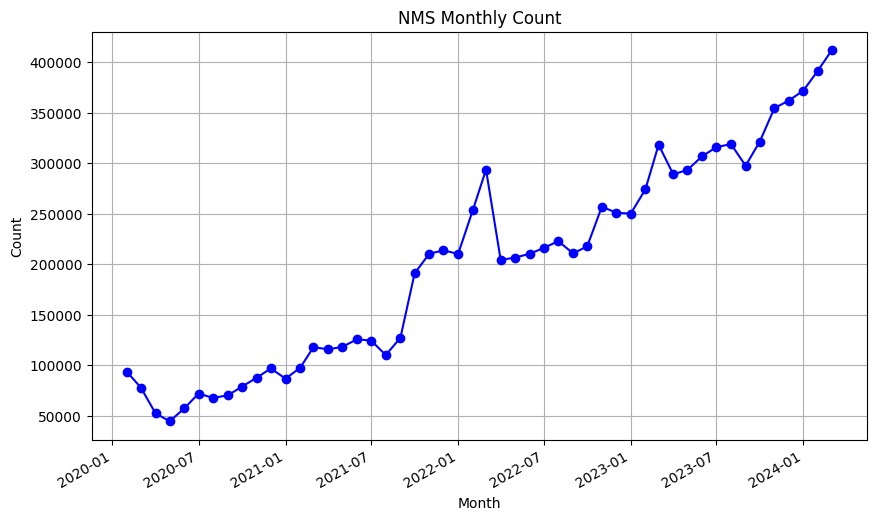

In [54]:
df=nms_count_df
# Convert 'month' column to datetime format
df['month'] = pd.to_datetime(df['month'], format='%Y%m')

df = df[df['month'] > '2020-01-01']

# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(df['month'], df['count'], marker='o', linestyle='-', color='b')

# Set the title and labels
plt.title('NMS Monthly Count')
plt.xlabel('Month')
plt.ylabel('Count')

# Improve date formatting on x-axis
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))

# Rotate date labels for better readability
plt.gcf().autofmt_xdate()

# Show the plot
plt.grid(True)
plt.show()